In [1]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py
import librosa
import os as os
import pandas as pd
import re
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from matplotlib import cm, colors, colorbar
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
rdg = RidgeClassifier(alpha=0.5)
#mlp=MLPClassifier(random_state=1,max_iter=300,activation='relu',solver='sgd',learning_rate='constant',learning_rate_init=0.0001)
mlp=MLPClassifier(random_state=1,max_iter=300,activation='relu')
from sklearn.linear_model import LogisticRegression
lgr=LogisticRegression(random_state=1,max_iter=500)
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(random_state=0,max_depth=10)
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(n_estimators=100, random_state=0)
from sklearn.ensemble import GradientBoostingClassifier
gbc= GradientBoostingClassifier(n_estimators=100, random_state=1)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
from sklearn.linear_model import SGDClassifier
#SGD=SGDClassifier(loss= 'log',random_state=1,max_iter=100,early_stopping=True,learning_rate='optimal',validation_fraction=0.2)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
mmscaler= MinMaxScaler()
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=10, random_state=0)
from sklearn.svm import SVC
clf_svm=SVC(kernel='rbf')
linear_svm=SVC(kernel='linear')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.stats.mstats import mquantiles
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.model_selection import LeaveOneOut
pca = PCA(n_components=2, svd_solver='full')
import random
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

2023-11-10 18:53:03.385302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 18:53:03.501628: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 18:53:03.964742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-10 18:53:03.964806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def read_eeg(data):
    with open(data) as f:
        raw = []
        for line in f:
            line = line.split() # to deal with blank 
            if line:            # lines (ie skip them)
                line = [int(float(i)) for i in line]
                raw.append(line)
    df = pd.DataFrame (raw,columns=['Channel_1','Channel_2','Channel_3','Channel_4','Channel_5','Channel_6','Channel_7','Channel_8',
                            'Channel_9','Channel_10','Channel_11','Channel_12','Channel_13','Channel_14','Channel_15'
                             ,'Channel_16','Channel_17','Channel_18','Channel_19'])
    return df

from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def noise_filter(df):
    filt_data=pd.Series()
    for i in range(0, df.shape[1]):
        signal = df.iloc[:,i].values
        data=butter_bandpass_filter(signal,0.1,45,128,3)
        
        filt_data=pd.concat([filt_data,pd.Series(data)],axis=1)
    filt_data=filt_data.iloc[:,1:]
    filt_data.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19']
    return filt_data

In [3]:
total_tps=34944-5*128 # cut all EEG of all subjects into equal length = 34944-5*128=34304 time points
number_of_epochs=26 # segment each subject's EEG into 26 epochs
number_of_tps=1280 # each epoch include 1280 time points

In [4]:
os.chdir("/home/jupy/Raw_data/Time_0/Obese")
ob_0=os.listdir(os.getcwd())
ob_0.remove('.ipynb_checkpoints')
#ob_0.remove('New')

eeg_ob_0=np.zeros([len(ob_0),total_tps,19])
for i in range(0,len(ob_0)):
    eeg_ob_0[i,:,:]=(read_eeg(ob_0[i]).values)[0:total_tps,:]

os.chdir("/home/jupy/Raw_data/Time_0/Lean")
l_0=os.listdir(os.getcwd())
l_0.remove('.ipynb_checkpoints')
#l_0.remove('New')

eeg_l_0=np.zeros([len(l_0),total_tps,19])
for i in range(0,len(l_0)):
    eeg_l_0[i,:,:]=(read_eeg(l_0[i]).values)[0:total_tps,:]
    
X_0=np.vstack([eeg_ob_0,eeg_l_0])
print ('eeg_ob_0',eeg_ob_0.shape)
print ('eeg_l_0',eeg_l_0.shape)
print('X_0',X_0.shape)

eeg_ob_0 (30, 34304, 19)
eeg_l_0 (30, 34304, 19)
X_0 (60, 34304, 19)


In [5]:
y=[0]*30+[1]*30

X_0_clean=np.zeros([60, 34304, 19])
for i in range(0,X_0.shape[0]):
    X_0_clean[i,:,:]=noise_filter(pd.DataFrame(X_0[i,:,:]))
X_0_clean=X_0_clean[:,0:int(number_of_epochs*number_of_tps),:]

X2_0=np.zeros([number_of_epochs*X_0_clean.shape[0],int(number_of_tps),19])
for chan in range(0,19):
    X1=np.zeros([number_of_epochs*X_0_clean.shape[0],int(number_of_tps)])
    for subj in range(0,X_0_clean.shape[0]):
        X1[subj*number_of_epochs:(subj+1)*number_of_epochs,:]=X_0_clean[subj,0:int(number_of_epochs*number_of_tps),chan].reshape(int(number_of_epochs),int(number_of_tps))
    X2_0[:,:,chan]=X1

/tmp/ipykernel_52075/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_52075/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_52075/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_52075/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_52075/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' ins

In [6]:
XX_0=np.zeros([X2_0.shape[0],19,number_of_tps])
for i in range(0,X2_0.shape[0]):
    XX_0[i,:,:]=X2_0[i,:,:].transpose()
print(XX_0.shape)

(1560, 19, 1280)


In [7]:
Y2=[]
for n in y:
    Y2=Y2+[n]*number_of_epochs
len(Y2)

1560

In [8]:
del eeg_l_0
del eeg_ob_0
del X_0
del X_0_clean
del X2_0

In [9]:
y_test_short=[1,1,1,0,0,0]

def subj_class_prob(result):
    pred=[]
    for i in range(0,6):
        #print(np.where(np.array(result[i*number_of_epochs:(i+1)*number_of_epochs])==1)[0].shape[0]/number_of_epochs)
        print(sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[0], sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[1])
        if sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[0]>sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[1]:
            pred.append(0)
        else:
            pred.append(1)
    return pred

In [11]:
import math
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense
from tensorflow.keras.layers import multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from tensorflow.keras.layers import Dropout, MultiHeadAttention, LayerNormalization, Reshape
from tensorflow.keras import backend as K


#%% Create and apply the attention model
def attention_block(net, attention_model): 
    in_sh = net.shape # dimensions of the input tensor
    in_len = len(in_sh) 
    expanded_axis = 3 # defualt = 3
    
    if attention_model == 'mha':   # Multi-head self attention layer 
        if(in_len > 3):
            net = Reshape((in_sh[1],-1))(net)
        net = mha_block(net)
    elif attention_model == 'mhla':  # Multi-head local self-attention layer 
        if(in_len > 3):
            net = Reshape((in_sh[1],-1))(net)
        net = mha_block(net, vanilla = False)
    elif attention_model == 'se':   # Squeeze-and-excitation layer
        if(in_len < 4):
            net = tf.expand_dims(net, axis=expanded_axis)
        net = se_block(net, ratio=8)
    elif attention_model == 'cbam': # Convolutional block attention module
        if(in_len < 4):
            net = tf.expand_dims(net, axis=expanded_axis)
        net = cbam_block(net, ratio=8)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))
        
    if (in_len == 3 and len(net.shape) == 4):
        net = K.squeeze(net, expanded_axis)
    elif (in_len == 4 and len(net.shape) == 3):
        net = Reshape((in_sh[1], in_sh[2], in_sh[3]))(net)
    return net


#%% Multi-head self Attention (MHA) block
def mha_block(input_feature, key_dim=8, num_heads=2, dropout = 0.5, vanilla = True):
    """Multi Head self Attention (MHA) block.     
       
    Here we include two types of MHA blocks: 
            The original multi-head self-attention as described in https://arxiv.org/abs/1706.03762
            The multi-head local self attention as described in https://arxiv.org/abs/2112.13492v1
    """    
    # Layer normalization
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    
    if vanilla:
        # Create a multi-head attention layer as described in 
        # 'Attention Is All You Need' https://arxiv.org/abs/1706.03762
        x = MultiHeadAttention(key_dim = key_dim, num_heads = num_heads, dropout = dropout)(x, x)
    else:
        # Create a multi-head local self-attention layer as described in 
        # 'Vision Transformer for Small-Size Datasets' https://arxiv.org/abs/2112.13492v1
        
        # Build the diagonal attention mask
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        
        # Create a multi-head local self attention layer.
        x = MultiHeadAttention_LSA(key_dim = key_dim, num_heads = num_heads, dropout = dropout)(
            x, x, attention_mask = diag_attn_mask)
        
    x = Dropout(0.3)(x)
    # Skip connection
    mha_feature = Add()([input_feature, x])
    
    return mha_feature


#%% Multi head self Attention (MHA) block: Locality Self Attention (LSA)
class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    """local multi-head self attention block
     
     Locality Self Attention as described in https://arxiv.org/abs/2112.13492v1
     This implementation is taken from  https://keras.io/examples/vision/vit_small_ds/ 
    """    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is the square 
        # root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


#%% Squeeze-and-excitation block
def se_block(input_feature, ratio=8):
	"""Squeeze-and-Excitation(SE) block.
    
	As described in https://arxiv.org/abs/1709.01507
    The implementation is taken from https://github.com/kobiso/CBAM-keras
	"""
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	se_feature = Dense(channel // ratio,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)

	se_feature = multiply([input_feature, se_feature])
	return se_feature


#%% Convolutional block attention module
def cbam_block(cbam_feature, ratio=8):
	""" Convolutional Block Attention Module(CBAM) block.
    
	As described in https://arxiv.org/abs/1807.06521
    The implementation is taken from https://github.com/kobiso/CBAM-keras
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
# 	channel = input_feature._keras_shape[channel_axis]
	channel = input_feature.shape[channel_axis]
    
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])
		
	

In [14]:
XX_0.shape

(1560, 19, 1280)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, LayerNormalization, Flatten 
from tensorflow.keras.layers import Add, Concatenate, Lambda, Input, Permute
from tensorflow.keras.constraints import max_norm

from tensorflow.keras import backend as K

def ATCNet(n_classes, in_chans = 29, in_samples = 1280, n_windows = 3, attention = None, 
           eegn_F1 = 16, eegn_D = 2, eegn_kernelSize = 64, eegn_poolSize = 8, eegn_dropout=0.3, 
           tcn_depth = 2, tcn_kernelSize = 4, tcn_filters = 32, tcn_dropout = 0.3, 
           tcn_activation = 'elu', fuse = 'average'):
    """ ATCNet model from Altaheri et al 2022.
        See details at https://ieeexplore.ieee.org/abstract/document/9852687
    
        Notes
        -----
        The initial values in this model are based on the values identified by
        the authors
        
        References
        ----------
        .. H. Altaheri, G. Muhammad and M. Alsulaiman, "Physics-informed 
           attention temporal convolutional network for EEG-based motor imagery 
           classification," in IEEE Transactions on Industrial Informatics, 2022, 
           doi: 10.1109/TII.2022.3197419.
    """
    input_1 = Input(shape = (1,in_chans, in_samples))   #     TensorShape([None, 1, 22, 1125])
    input_2 = Permute((3,2,1))(input_1) 
    regRate=.25
    numFilters = eegn_F1
    F2 = numFilters*eegn_D

    block1 = Conv_block(input_layer = input_2, F1 = eegn_F1, D = eegn_D, 
                        kernLength = eegn_kernelSize, poolSize = eegn_poolSize,
                        in_chans = in_chans, dropout = eegn_dropout)
    block1 = Lambda(lambda x: x[:,:,-1,:])(block1)
     
    # Sliding window 
    sw_concat = []   # to store concatenated or averaged sliding window outputs
    for i in range(n_windows):
        st = i
        end = block1.shape[1]-n_windows+i+1
        block2 = block1[:, st:end, :]
        
        # Attention_model
        if attention is not None:
            block2 = attention_block(block2, attention)

        # Temporal convolutional network (TCN)
        block3 = TCN_block(input_layer = block2, input_dimension = F2, depth = tcn_depth,
                            kernel_size = tcn_kernelSize, filters = tcn_filters, 
                            dropout = tcn_dropout, activation = tcn_activation)
        # Get feature maps of the last sequence
        block3 = Lambda(lambda x: x[:,-1,:])(block3)
        
        # Outputs of sliding window: Average_after_dense or concatenate_then_dense
        if(fuse == 'average'):
            sw_concat.append(Dense(n_classes, kernel_constraint = max_norm(regRate))(block3))
        elif(fuse == 'concat'):
            if i == 0:
                sw_concat = block3
            else:
                sw_concat = Concatenate()([sw_concat, block3])
                
    if(fuse == 'average'):
        if len(sw_concat) > 1: # more than one window
            sw_concat = tf.keras.layers.Average()(sw_concat[:])
        else: # one window (# windows = 1)
            sw_concat = sw_concat[0]
    elif(fuse == 'concat'):
        sw_concat = Dense(n_classes, kernel_constraint = max_norm(regRate))(sw_concat)
            
    
    softmax = Activation('softmax', name = 'softmax')(sw_concat)
    
    return Model(inputs = input_1, outputs = softmax)

In [40]:

#from attention_models import attention_block
        
#%% The proposed ATCNet model, https://doi.org/10.1109/TII.2022.3197419


#%% Convolutional (CV) block used in the ATCNet model
def Conv_block(input_layer, F1=4, kernLength=64, poolSize=8, D=2, in_chans=22, dropout=0.1):
    """ Conv_block
    
        Notes
        -----
        This block is the same as EEGNet with SeparableConv2D replaced by Conv2D 
        The original code for this model is available at: https://github.com/vlawhern/arl-eegmodels
        See details at https://arxiv.org/abs/1611.08024
    """
    F2= F1*D
    block1 = Conv2D(F1, (kernLength, 1), padding = 'same',data_format='channels_last',use_bias = False)(input_layer)
    block1 = BatchNormalization(axis = -1)(block1)
    block2 = DepthwiseConv2D((1, in_chans), use_bias = False, 
                                    depth_multiplier = D,
                                    data_format='channels_last',
                                    depthwise_constraint = max_norm(1.))(block1)
    block2 = BatchNormalization(axis = -1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8,1),data_format='channels_last')(block2)
    block2 = Dropout(dropout)(block2)
    block3 = Conv2D(F2, (16, 1),
                            data_format='channels_last',
                            use_bias = False, padding = 'same')(block2)
    block3 = BatchNormalization(axis = -1)(block3)
    block3 = Activation('elu')(block3)
    
    block3 = AveragePooling2D((poolSize,1),data_format='channels_last')(block3)
    block3 = Dropout(dropout)(block3)
    return block3

#%% Temporal convolutional (TC) block used in the ATCNet model
def TCN_block(input_layer,input_dimension,depth,kernel_size,filters,dropout,activation='relu'):
    """ TCN_block from Bai et al 2018
        Temporal Convolutional Network (TCN)
        
        Notes
        -----
        THe original code available at https://github.com/locuslab/TCN/blob/master/TCN/tcn.py
        This implementation has a slight modification from the original code
        and it is taken from the code by Ingolfsson et al at https://github.com/iis-eth-zurich/eeg-tcnet
        See details at https://arxiv.org/abs/2006.00622

        References
        ----------
        .. Bai, S., Kolter, J. Z., & Koltun, V. (2018).
           An empirical evaluation of generic convolutional and recurrent networks
           for sequence modeling.
           arXiv preprint arXiv:1803.01271.
    """    
    
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(input_layer)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    if(input_dimension != filters):
        conv = Conv1D(filters,kernel_size=1,padding='same')(input_layer)
        added = Add()([block,conv])
    else:
        added = Add()([block,input_layer])
    out = Activation(activation)(added)
    
    for i in range(depth-1):
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(out)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        added = Add()([block, out])
        out = Activation(activation)(added)
        
    return out
def EEGNet(input_layer, F1=8, kernLength=64, D=2, Chans=22, dropout=0.25):
    """ EEGNet model from Lawhern et al 2018
    See details at https://arxiv.org/abs/1611.08024
    
    The original code for this model is available at: https://github.com/vlawhern/arl-eegmodels
    
        Notes
        -----
        The initial values in this model are based on the values identified by the authors
        
        References
        ----------
        .. Lawhern, V. J., Solon, A. J., Waytowich, N. R., Gordon,
           S. M., Hung, C. P., & Lance, B. J. (2018).
           EEGNet: A Compact Convolutional Network for EEG-based
           Brain-Computer Interfaces.
           arXiv preprint arXiv:1611.08024.
    """
    F2= F1*D
    block1 = Conv2D(F1, (kernLength, 1), padding = 'same',data_format='channels_last',use_bias = False)(input_layer)
    block1 = BatchNormalization(axis = -1)(block1)
    block2 = DepthwiseConv2D((1, Chans), use_bias = False, 
                                    depth_multiplier = D,
                                    data_format='channels_last',
                                    depthwise_constraint = max_norm(1.))(block1)
    block2 = BatchNormalization(axis = -1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8,1),data_format='channels_last')(block2)
    block2 = Dropout(dropout)(block2)
    block3 = SeparableConv2D(F2, (16, 1),
                            data_format='channels_last',
                            use_bias = False, padding = 'same')(block2)
    block3 = BatchNormalization(axis = -1)(block3)
    block3 = Activation('elu')(block3)
    block3 = AveragePooling2D((8,1),data_format='channels_last')(block3)
    block3 = Dropout(dropout)(block3)
    return block3



#%% Reproduced TCNet_Fusion model: https://doi.org/10.1016/j.bspc.2021.102826
def TCNet_Fusion(n_classes,Chans=19, Samples=1280, layers=2, kernel_s=4, filt=12,
                 dropout=0.3, activation='elu', F1=24, D=2, kernLength=32, dropout_eeg=0.3):
    """ TCNet_Fusion model from Musallam et al 2021.
    See details at https://doi.org/10.1016/j.bspc.2021.102826
    
        Notes
        -----
        The initial values in this model are based on the values identified by
        the authors
        
        References
        ----------
        .. Musallam, Y.K., AlFassam, N.I., Muhammad, G., Amin, S.U., Alsulaiman,
           M., Abdul, W., Altaheri, H., Bencherif, M.A. and Algabri, M., 2021. 
           Electroencephalography-based motor imagery classification
           using temporal convolutional network fusion. 
           Biomedical Signal Processing and Control, 69, p.102826.
    """
    input1 = Input(shape = (1,Chans, Samples))
    input2 = Permute((3,2,1))(input1)
    regRate=.25

    numFilters = F1
    F2= numFilters*D
    
    EEGNet_sep = EEGNet(input_layer=input2,F1=F1,kernLength=kernLength,D=D,Chans=Chans,dropout=dropout_eeg)
    block2 = Lambda(lambda x: x[:,:,-1,:])(EEGNet_sep)
    FC = Flatten()(block2) 

    outs = TCN_block(input_layer=block2,input_dimension=F2,depth=layers,kernel_size=kernel_s,filters=filt,dropout=dropout,activation=activation)

    Con1 = Concatenate()([block2,outs]) 
    out = Flatten()(Con1) 
    Con2 = Concatenate()([out,FC]) 
    dense        = Dense(n_classes, name = 'dense',kernel_constraint = max_norm(regRate))(Con2)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1,outputs=softmax)

In [23]:
s_range=range(0,1)

In [28]:
data_ind=[]
for n in range(0,10):
    data_ind.append(np.array([30,31,32,0,1,2])+n*3)

Xtest_id={}
Xtv_id={}


for s in s_range:    
    Xtest_id[s]=data_ind[s]
    #Xtv_id[s]=flatten(data_ind[0:s]+data_ind[(s+1):])
    Xtv_id[s]=(np.array(data_ind[0:s]).flatten().tolist())+(np.array(data_ind[(s+1):]).flatten().tolist())
    print('set',s,Xtest_id[s])
    print('set',s,Xtv_id[s])
    print('----------------------------')
    
Xdata= XX_0
Ydata=np.array(Y2)#quality_y#
Xtv={}
Ytv={}
Xtest={}
Ytest={}
for s in s_range:
    print('set',s)
    Xtest[s]=np.zeros([Xdata.shape[0],Xdata.shape[1],Xdata.shape[2]])
    Ytest[s]=np.zeros([Xdata.shape[0],])
    print('test_id',Xtest_id[s])
    for test_id in Xtest_id[s]:
            Xtest[s]=np.vstack([Xtest[s],Xdata[test_id*number_of_epochs:(test_id+1)*number_of_epochs,:,:]])
            Ytest[s]=np.hstack([Ytest[s],Ydata[test_id*number_of_epochs:(test_id+1)*number_of_epochs,]])
          
    Xtest[s]=Xtest[s][Xdata.shape[0]:,:,:] 
    Ytest[s]=Ytest[s][Xdata.shape[0]:,] 
    
    Xtv[s]=np.zeros([Xdata.shape[0],Xdata.shape[1],Xdata.shape[2]])
    Ytv[s]=np.zeros([Xdata.shape[0],])
    print('tv_id',Xtv_id[s])
    for tv_id in Xtv_id[s]:
            Xtv[s]=np.vstack([Xtv[s],Xdata[tv_id*number_of_epochs:(tv_id+1)*number_of_epochs,:,:]])
            Ytv[s]=np.hstack([Ytv[s],Ydata[tv_id*number_of_epochs:(tv_id+1)*number_of_epochs,]])
            
    Xtv[s]=Xtv[s][Xdata.shape[0]:,:,:] 
    Ytv[s]=Ytv[s][Xdata.shape[0]:,] 

set 0 [30 31 32  0  1  2]
set 0 [33, 34, 35, 3, 4, 5, 36, 37, 38, 6, 7, 8, 39, 40, 41, 9, 10, 11, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22, 23, 54, 55, 56, 24, 25, 26, 57, 58, 59, 27, 28, 29]
----------------------------
set 0
test_id [30 31 32  0  1  2]
tv_id [33, 34, 35, 3, 4, 5, 36, 37, 38, 6, 7, 8, 39, 40, 41, 9, 10, 11, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22, 23, 54, 55, 56, 24, 25, 26, 57, 58, 59, 27, 28, 29]


In [29]:
all_id_long={}
X_all_shuffled={}
Y_all_shuffled={}
Y_all_shuffled_cat={}
for s in s_range:
    np.random.seed(2)
    all_id_long[s]=np.arange(0,Xtv[s].shape[0])
    np.random.shuffle(all_id_long[s])
    
    X_all_shuffled[s]=np.zeros([ Xtv[s].shape[0], Xtv[s].shape[1],Xtv[s].shape[2]])
    Y_all_shuffled[s]=np.zeros([ Xtv[s].shape[0]])
    for n in range(0,all_id_long[s].shape[0]):
        X_all_shuffled[s][n,:,:]=Xtv[s][all_id_long[s][n],:,:]
        #print(n,all_id_long[s][n])
        Y_all_shuffled[s][n]=Ytv[s][all_id_long[s][n]]
    print(X_all_shuffled[s].shape)
    print(Y_all_shuffled[s].shape)

(1404, 19, 1280)
(1404,)


In [ ]:
from sklearn.manifold import TSNE
tsne= TSNE(n_components=2, perplexity=15)

# https://github.com/Altaheri/EEG-ATCNet/blob/main/models.py

# atcNET

In [ ]:
model =ATCNet(n_classes=2, in_chans = 19, in_samples = 1280, n_windows = 3, attention = None, 
           eegn_F1 = 16, eegn_D = 2, eegn_kernelSize = 64, eegn_poolSize = 8, eegn_dropout=0.3, 
           tcn_depth = 2, tcn_kernelSize = 4, tcn_filters = 32, tcn_dropout = 0.3, 
           tcn_activation = 'elu', fuse = 'average')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
    lr=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005, decay_steps=50, decay_rate=0.9, staircase=False, name=None
    )
    adam=tf.keras.optimizers.Adam(learning_rate=0.001)#learning_rate=0.0005

    model.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights = True)
    history=model.fit( X_all_shuffled[s].reshape(1404,1,19,1280),
                          to_categorical(Y_all_shuffled[s]),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1) 


Epoch 1/100
12/12 [==============================] - 16s 1s/step - loss: 0.7367 - accuracy: 0.4987 - val_loss: 0.7043 - val_accuracy: 0.4520
Epoch 2/100
12/12 [==============================] - 12s 1s/step - loss: 0.6820 - accuracy: 0.5637 - val_loss: 0.6965 - val_accuracy: 0.4733
Epoch 3/100
12/12 [==============================] - 12s 1s/step - loss: 0.6722 - accuracy: 0.5761 - val_loss: 0.6799 - val_accuracy: 0.6121
Epoch 4/100
12/12 [==============================] - 12s 1s/step - loss: 0.6543 - accuracy: 0.6073 - val_loss: 0.6748 - val_accuracy: 0.6014
Epoch 5/100
12/12 [==============================] - 12s 1s/step - loss: 0.6438 - accuracy: 0.6189 - val_loss: 0.6727 - val_accuracy: 0.5730
Epoch 6/100
12/12 [==============================] - 12s 1s/step - loss: 0.6274 - accuracy: 0.6563 - val_loss: 0.6795 - val_accuracy: 0.5623
Epoch 7/100
12/12 [==============================] - 12s 1s/step - loss: 0.5989 - accuracy: 0.6776 - val_loss: 0.7021 - val_accuracy: 0.5658
Epoch 8/100
1

In [36]:
for s in s_range:
    #classifier=load_model(f'n_set{s}_btw_encoder_T0_classifier')
    classifier=atcnet
    result=[]
    predicted=classifier.predict(Xtest[s].reshape(156,1,19,1280))
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

5/5 [==============================] - 1s 108ms/step
ep score 0.6794871794871795
24.376589 1.6234121
6.496202 19.503798
4.2286024 21.7714
25.983496 0.016503565
21.884172 4.115828
13.285993 12.714005
score 0.8333333333333334


In [38]:
atcnet=model

In [100]:
#atcnet.summary()

In [79]:
intermediate_layer_model = Model(inputs=atcnet.input,outputs=atcnet.get_layer('conv1d_11').output)
acnet_feat= intermediate_layer_model.predict(X_all_shuffled[s].reshape(1404,1,19,1280))

acnet_feat_out=np.zeros([1404,int(18*32)])
for i in range(0,acnet_feat.shape[0]):
    acnet_feat_out[i,:]=acnet_feat[i,:,:].flatten()
    

tsne_acnet=tsne.fit_transform(acnet_feat_out)

for i in [0, 10, 20, 29, 31, 40, 48, 59]:
    if i < 30:
        plt.scatter(
            tsne_acnet[i * 26:(i + 1) * 26, 0],
            tsne_acnet[i * 26:(i + 1) * 26, 1],
            alpha=0.7, marker='+',
            s=50, label='Lean')
    else:
        plt.scatter(
            tsne_acnet[i * 26:(i + 1) * 26, 0],
            tsne_acnet[i * 26:(i + 1) * 26, 1],
            alpha=0.5, marker='o',
            s=50, label='Obese')

#plt.legend(['Lean', 'Obese'])
plt.show()

44/44 [==============================] - 5s 111ms/step


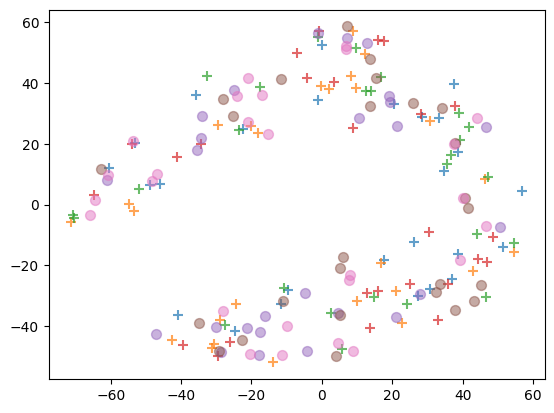

# TCnet

In [42]:
tcnet =TCNet_Fusion(n_classes=2,Chans=19, Samples=1280, layers=2, kernel_s=4, filt=12,
                 dropout=0.3, activation='elu', F1=24, D=2, kernLength=32, dropout_eeg=0.3)
tcnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
    lr=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005, decay_steps=50, decay_rate=0.9, staircase=False, name=None
    )
    adam=tf.keras.optimizers.Adam(learning_rate=0.001)#learning_rate=0.0005

    tcnet.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights = True)
    history=tcnet.fit( X_all_shuffled[s].reshape(1404,1,19,1280),
                          to_categorical(Y_all_shuffled[s]),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1) 


Epoch 1/100
12/12 [==============================] - 11s 801ms/step - loss: 0.7189 - accuracy: 0.5325 - val_loss: 0.6908 - val_accuracy: 0.5765
Epoch 2/100
12/12 [==============================] - 9s 785ms/step - loss: 0.6446 - accuracy: 0.5993 - val_loss: 0.6863 - val_accuracy: 0.5872
Epoch 3/100
12/12 [==============================] - 9s 783ms/step - loss: 0.6136 - accuracy: 0.6402 - val_loss: 0.6855 - val_accuracy: 0.6335
Epoch 4/100
12/12 [==============================] - 9s 779ms/step - loss: 0.5639 - accuracy: 0.7079 - val_loss: 0.6820 - val_accuracy: 0.5694
Epoch 5/100
12/12 [==============================] - 9s 782ms/step - loss: 0.5100 - accuracy: 0.7542 - val_loss: 0.6758 - val_accuracy: 0.6121
Epoch 6/100
12/12 [==============================] - 9s 782ms/step - loss: 0.4740 - accuracy: 0.7898 - val_loss: 0.6713 - val_accuracy: 0.6335
Epoch 7/100
12/12 [==============================] - 9s 784ms/step - loss: 0.4245 - accuracy: 0.8130 - val_loss: 0.6594 - val_accuracy: 0.782

In [45]:
for s in s_range:
    #classifier=load_model(f'n_set{s}_btw_encoder_T0_classifier')
    classifier=tcnet
    result=[]
    predicted=classifier.predict(Xtest[s].reshape(156,1,19,1280))
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

5/5 [==============================] - 0s 69ms/step
ep score 0.6474358974358975
24.726437 1.2735586
7.9421115 18.05789
7.687136 18.312862
25.999277 0.0007238236
25.79672 0.20327812
9.481551 16.518448
score 0.6666666666666666


In [90]:
#tcnet.summary()

44/44 [==============================] - 3s 70ms/step


/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


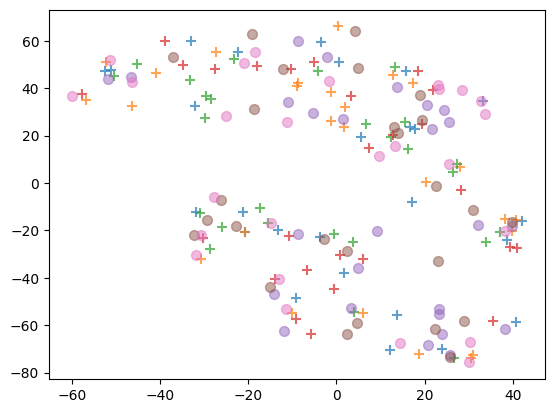

In [93]:
intermediate_layer_model = Model(inputs=tcnet.input,outputs=tcnet.get_layer('conv1d_16').output)
tcnet_feat= intermediate_layer_model.predict(X_all_shuffled[s].reshape(1404,1,19,1280))

tcnet_feat_out=np.zeros([1404,int(tcnet_feat.shape[1]*tcnet_feat.shape[2])])
for i in range(0,tcnet_feat.shape[0]):
    tcnet_feat_out[i,:]=tcnet_feat[i,:,:].flatten()
    

tsne_tcnet=tsne.fit_transform(tcnet_feat_out)

for i in [0, 10, 20, 29, 31, 40, 48, 59]:
    if i < 30:
        plt.scatter(
            tsne_tcnet[i * 26:(i + 1) * 26, 0],
            tsne_tcnet[i * 26:(i + 1) * 26, 1],
            alpha=0.7, marker='+',
            s=50, label='Lean')
    else:
        plt.scatter(
            tsne_tcnet[i * 26:(i + 1) * 26, 0],
            tsne_tcnet[i * 26:(i + 1) * 26, 1],
            alpha=0.5, marker='o',
            s=50, label='Obese')

#plt.legend(['Lean', 'Obese'])
plt.show()

# Deep COV net

In [65]:
def DeepConvNet(nb_classes, Chans = 19, Samples = 1280,
                dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    See details at https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23730
    
    The original code for this model is available at:
        https://github.com/braindecode/braindecode
    
    This implementation is taken from code by the Army Research Laboratory (ARL) 
    at https://github.com/vlawhern/arl-eegmodels
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """

    # start the model
    # input_main   = Input((Chans, Samples, 1))
    input_main   = Input((1, Chans, Samples))
    input_2 = Permute((2,3,1))(input_main) 
    
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_2)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

#%% need these for ShallowConvNet
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000)) 

In [66]:
deepconv_net =DeepConvNet(nb_classes=2,Chans=19,Samples=1280)
deepconv_net .compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
    lr=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005, decay_steps=50, decay_rate=0.9, staircase=False, name=None
    )
    adam=tf.keras.optimizers.Adam(learning_rate=0.001)#learning_rate=0.0005

    deepconv_net.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights = True)
    history=deepconv_net.fit( X_all_shuffled[s].reshape(1404,1,19,1280),
                          to_categorical(Y_all_shuffled[s]),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1) 


Epoch 1/100
12/12 [==============================] - 6s 411ms/step - loss: 1.0912 - accuracy: 0.5236 - val_loss: 0.6849 - val_accuracy: 0.5765
Epoch 2/100
12/12 [==============================] - 5s 400ms/step - loss: 0.8141 - accuracy: 0.5272 - val_loss: 0.7768 - val_accuracy: 0.5623
Epoch 3/100
12/12 [==============================] - 5s 401ms/step - loss: 1.0143 - accuracy: 0.5218 - val_loss: 0.6650 - val_accuracy: 0.5943
Epoch 4/100
12/12 [==============================] - 5s 401ms/step - loss: 0.9450 - accuracy: 0.5370 - val_loss: 1.1602 - val_accuracy: 0.5694
Epoch 5/100
12/12 [==============================] - 5s 399ms/step - loss: 0.8746 - accuracy: 0.5646 - val_loss: 0.7044 - val_accuracy: 0.5623
Epoch 6/100
12/12 [==============================] - 5s 401ms/step - loss: 0.7342 - accuracy: 0.5904 - val_loss: 0.7466 - val_accuracy: 0.5658
Epoch 7/100
12/12 [==============================] - 5s 401ms/step - loss: 0.7677 - accuracy: 0.5966 - val_loss: 0.7181 - val_accuracy: 0.5623

In [68]:
for s in s_range:
    #classifier=load_model(f'n_set{s}_btw_encoder_T0_classifier')
    classifier=deepconv_net
    result=[]
    predicted=classifier.predict(Xtest[s].reshape(156,1,19,1280))
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

5/5 [==============================] - 0s 32ms/step
ep score 0.5769230769230769
25.995773 0.0042255237
10.9482155 15.051785
7.692834 18.307167
25.999287 0.0007098821
23.759884 2.2401187
4.548243 21.451756
score 0.6666666666666666


In [97]:
#deepconv_net.summary()

44/44 [==============================] - 1s 32ms/step


/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


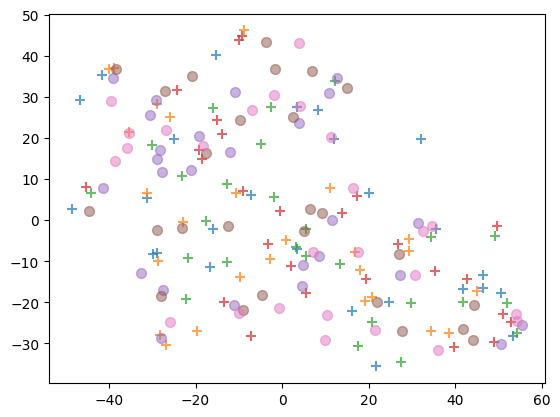

In [99]:
intermediate_layer_model = Model(inputs=deepconv_net.input,outputs=deepconv_net.get_layer('conv2d_26').output)
deepconv_net_feat= intermediate_layer_model.predict(X_all_shuffled[s].reshape(1404,1,19,1280)).reshape(1404, 152, 200)

deepconv_net_feat_out=np.zeros([1404,int(deepconv_net_feat.shape[1]*deepconv_net_feat.shape[2])])
for i in range(0,deepconv_net_feat.shape[0]):
    deepconv_net_feat_out[i,:]=deepconv_net_feat[i,:,:].flatten()
    

tsne_deepconv_net=tsne.fit_transform(deepconv_net_feat_out)

for i in [0, 10, 20, 29, 31, 40, 48, 59]:
    if i < 30:
        plt.scatter(
            tsne_deepconv_net[i * 26:(i + 1) * 26, 0],
            tsne_deepconv_net[i * 26:(i + 1) * 26, 1],
            alpha=0.7, marker='+',
            s=50, label='Lean')
    else:
        plt.scatter(
            tsne_deepconv_net[i * 26:(i + 1) * 26, 0],
            tsne_deepconv_net[i * 26:(i + 1) * 26, 1],
            alpha=0.5, marker='o',
            s=50, label='Obese')

#plt.legend(['Lean', 'Obese'])
plt.show()

In [ ]:
# ShallowCOV net

In [56]:
def ShallowConvNet(nb_classes=2, Chans = 19, Samples = 128, dropoutRate = 0.5):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.
    See details at https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23730
    
    The original code for this model is available at:
        https://github.com/braindecode/braindecode

    This implementation is taken from code by the Army Research Laboratory (ARL) 
    at https://github.com/vlawhern/arl-eegmodels

    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in 
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is 
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25    
    
    Note that this implementation has not been verified by the original 
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations. 
    """

    # start the model
    # input_main   = Input((Chans, Samples, 1))
    input_main   = Input((1, Chans, Samples))
    input_2 = Permute((2,3,1))(input_main) 

    block1       = Conv2D(40, (1, 13), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_2)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

In [63]:
shallowconv_net =ShallowConvNet(nb_classes=2,Chans=19,Samples=1280)
shallowconv_net .compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
    lr=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005, decay_steps=50, decay_rate=0.9, staircase=False, name=None
    )
    adam=tf.keras.optimizers.Adam(learning_rate=0.001)#learning_rate=0.0005

    shallowconv_net.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights = True)
    history=shallowconv_net.fit( X_all_shuffled[s].reshape(1404,1,19,1280),
                          to_categorical(Y_all_shuffled[s]),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1) 


Epoch 1/100
12/12 [==============================] - 5s 408ms/step - loss: 3.3699 - accuracy: 0.4951 - val_loss: 1.1362 - val_accuracy: 0.5018
Epoch 2/100
12/12 [==============================] - 5s 399ms/step - loss: 2.1026 - accuracy: 0.5272 - val_loss: 0.9336 - val_accuracy: 0.5730
Epoch 3/100
12/12 [==============================] - 5s 402ms/step - loss: 1.7020 - accuracy: 0.5485 - val_loss: 2.2991 - val_accuracy: 0.4377
Epoch 4/100
12/12 [==============================] - 5s 398ms/step - loss: 2.4393 - accuracy: 0.5361 - val_loss: 3.3066 - val_accuracy: 0.4377
Epoch 5/100
12/12 [==============================] - 5s 400ms/step - loss: 1.1218 - accuracy: 0.5503 - val_loss: 1.1324 - val_accuracy: 0.4626
Epoch 6/100
12/12 [==============================] - 5s 398ms/step - loss: 0.9345 - accuracy: 0.6171 - val_loss: 0.6281 - val_accuracy: 0.6406
Epoch 7/100
12/12 [==============================] - 5s 399ms/step - loss: 1.0674 - accuracy: 0.5948 - val_loss: 1.0896 - val_accuracy: 0.4911

In [69]:
for s in s_range:
    #classifier=load_model(f'n_set{s}_btw_encoder_T0_classifier')
    classifier=shallowconv_net
    result=[]
    predicted=classifier.predict(Xtest[s].reshape(156,1,19,1280))
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

5/5 [==============================] - 0s 33ms/step
ep score 0.6282051282051282
17.30124 8.698758
12.620555 13.379445
3.7720041 22.227993
18.11661 7.88339
9.891998 16.108
19.64427 6.355727
score 0.6666666666666666


# EEGNET

In [70]:
def EEGNet(nb_classes=2, Chans = 19, Samples = 1280, 
             dropoutRate = 0.25, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',  #  3 
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)

    block1       = BatchNormalization()(block1)
    
   
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('relu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('relu')(block2)
    
    block2       = AveragePooling2D((1, 8))(block2)
    #block2       = tf.keras.layers.GlobalAveragePooling2D()(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    initializer = initializer = tf.keras.initializers.Identity()
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate),kernel_initializer=initializer)(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [72]:
    eegnet =EEGNet(nb_classes=2,Chans=19,Samples=1280)
    eegnet .compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    lr=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005, decay_steps=50, decay_rate=0.9, staircase=False, name=None
    )
    adam=tf.keras.optimizers.Adam(learning_rate=0.001)#learning_rate=0.0005

    eegnet.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights = True)
    history=eegnet.fit( X_all_shuffled[s].reshape(1404,19,1280,1),
                          to_categorical(Y_all_shuffled[s]),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1) 


Epoch 1/100
12/12 [==============================] - 6s 481ms/step - loss: 0.6951 - accuracy: 0.5227 - val_loss: 0.7028 - val_accuracy: 0.4413
Epoch 2/100
12/12 [==============================] - 6s 470ms/step - loss: 0.6681 - accuracy: 0.5975 - val_loss: 0.6974 - val_accuracy: 0.4413
Epoch 3/100
12/12 [==============================] - 6s 470ms/step - loss: 0.6388 - accuracy: 0.6242 - val_loss: 0.6957 - val_accuracy: 0.4520
Epoch 4/100
12/12 [==============================] - 6s 469ms/step - loss: 0.6247 - accuracy: 0.6563 - val_loss: 0.6830 - val_accuracy: 0.5836
Epoch 5/100
12/12 [==============================] - 6s 468ms/step - loss: 0.6025 - accuracy: 0.6616 - val_loss: 0.6791 - val_accuracy: 0.5907
Epoch 6/100
12/12 [==============================] - 6s 466ms/step - loss: 0.5725 - accuracy: 0.7008 - val_loss: 0.6606 - val_accuracy: 0.6406
Epoch 7/100
12/12 [==============================] - 6s 470ms/step - loss: 0.5325 - accuracy: 0.7435 - val_loss: 0.6491 - val_accuracy: 0.6477

In [74]:
for s in s_range:
    #classifier=load_model(f'n_set{s}_btw_encoder_T0_classifier')
    classifier=eegnet
    result=[]
    predicted=classifier.predict(Xtest[s].reshape(156,19,1280,1))
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

5/5 [==============================] - 0s 17ms/step
ep score 0.48717948717948717
24.652355 1.3476441
14.99731 11.002688
14.4202585 11.5797415
25.906471 0.09353099
11.448122 14.551878
14.886776 11.113225
score 0.3333333333333333


# VAE

In [10]:
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout,Add,LSTM,Reshape,Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,AveragePooling1D,GlobalAveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Conv1D,Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dense, Lambda, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Conv1D,Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dense, Lambda, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.preprocessing import minmax_scale

# feature extraction

In [11]:
os.chdir('/home/jupy/SavedModel/autoencoder/T0_to_T0')
#os.chdir('/home/jupy/SavedModel/autoencoder/T15_to_T15')
mm_feature_output_0_0={}
for n in range(0,60):#2-48
    xar_0=XX_0[n*26:(n+1)*26,:,:]
    xar_norm_0=np.zeros([xar_0.shape[0],xar_0.shape[1],xar_0.shape[2]])
    for i in range(0,xar_0.shape[0]):
        for j in range(0,xar_0.shape[1]):
            xar_norm_0[i,j,:]=minmax_scale(xar_0[i,j,:])
    xar_0=xar_norm_0
    xar_0=np.expand_dims(xar_0,axis=-1)
    mm=load_model(f'T0_to_T0_VAE{n}')

    intermediate_layer_model = Model(inputs=mm.input,outputs=mm.get_layer('spatial_conv').output)
    #intermediate_layer_model.compile(optimizer=Adam(learning_rate=0.001))
    mm_feature_output_0_0[n]= intermediate_layer_model.predict(xar_0)
    
adapt_auto_feat_0_0=np.zeros([26*60,1,1217,8])
for n in range(0,60):
    adapt_auto_feat_0_0[n*26:(n+1)*26,:,:,:]=mm_feature_output_0_0[n]
Adapt_feat_0_0=np.zeros([26*60,1217*8])
for i in range(0,adapt_auto_feat_0_0.shape[0]):
    Adapt_feat_0_0[i,:]=adapt_auto_feat_0_0[i,:,:,:].flatten()

2023-11-10 16:15:42.743594: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-10 16:15:42.743659: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (panata): /proc/driver/nvidia/version does not exist
2023-11-10 16:15:42.759168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 44ms/step


In [12]:
Adapt_feat_0_0.shape

(1560, 9736)

### Convex Hull


# Genetic Algorithm

0-125: good qulaity
126-220:middle quality
220-:bad quality

In [200]:
subj_y=[]
for i in range(0,int(Adapt_feat_0_0.shape[0]/26)):
     subj_y.append([i]*26)
subj_y=np.array(subj_y).flatten()
subj_y.shape

(1560,)

In [297]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


n_estimators = 200
rf = RandomForestClassifier(n_estimators=n_estimators, bootstrap=True)
X_train, X_test, y_train, y_test = train_test_split(Adapt_feat_0_0, quality_y, test_size=0.2, random_state=42,stratify=quality_y
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

rf.feature_importances_
feat_id=rf.feature_importances_.argsort()[-500:][::-1]

Accuracy: 0.7307692307692307


# clustering

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2) 
ardata=Adapt_feat_0_0
tsardata=tsne.fit_transform(ardata)

/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


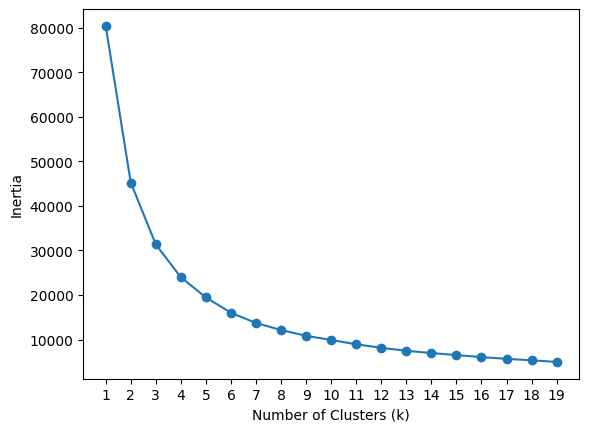

In [23]:
inertia = []
for k in range(1, 20):  # You can adjust the range of k as needed
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tsardata)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 20), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 20))
#plt.title('Elbow for Optimal k')
plt.show()

In [17]:
from sklearn.cluster import KMeans
n_clusters = 5 # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(ardata)
cluster_assignments = kmeans.labels_

In [18]:
cluster_assignments.shape
cluster_purity=[]
for i in range(0,60):
    cluster_count=(np.unique(cluster_assignments[i*26:(i+1)*26], return_counts=True)[0].shape[0])
    #print(np.unique(cluster_assignments[i*26:(i+1)*26], return_counts=True)[0].shape[0])
    cluster_purity.append(cluster_count)

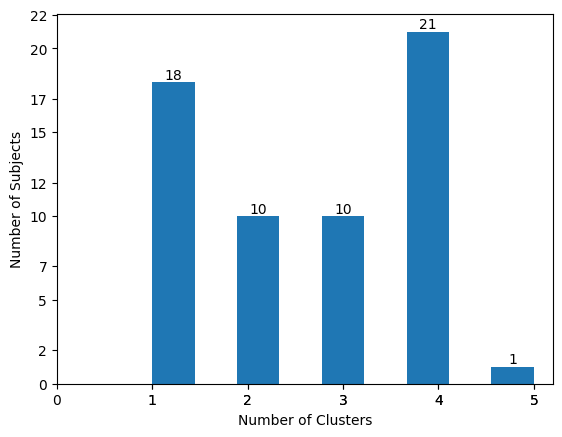

In [25]:
counts, bins, _ = plt.hist(cluster_purity, bins=9)
for count, x in zip(counts, bins):
    if count > 0:  # Remove 0 count
        plt.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Number of Clusters')
plt.ylabel('Number of Subjects')
#plt.title('Distribution of Data')
plt.xticks(list(map(int, plt.xticks()[0])))
plt.yticks(list(map(int, plt.yticks()[0])))

plt.show()


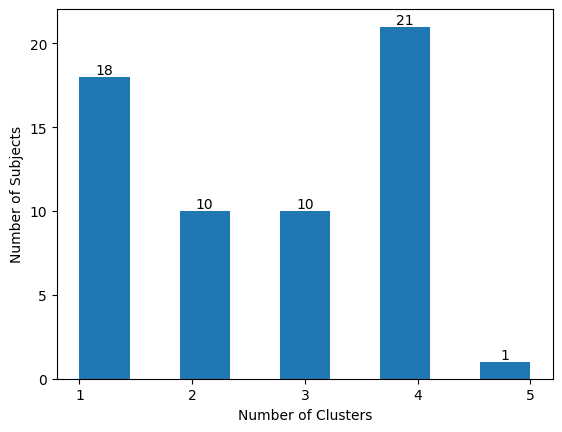

In [33]:
counts, bins, _ = plt.hist(cluster_purity, bins=9)
for count, x in zip(counts, bins):
    if count > 0:  # Remove 0 count
        plt.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Number of Clusters')
plt.ylabel('Number of Subjects')
plt.xticks(range(1, 6))  # Set the x-axis to start from 1 to 9
plt.yticks(range(0, 23, 5))  # Set the y-axis range from 0 to 22 with intervals of 5

plt.show()


In [388]:

good_q_id=np.where(np.array(cluster_purity)<=2)[0]
midhigh_q_id = np.where((2 < np.array(cluster_purity)) & (np.array(cluster_purity) <=3))[0]
midlow_q_id = np.where((3< np.array(cluster_purity)) & (np.array(cluster_purity) <= 3.5))[0]
bad_q_id = np.where(np.array(cluster_purity)>3.5)[0]

print('good subj',good_q_id)
print('midhigh subj',midhigh_q_id)
print('midlow subj',midlow_q_id)
print('bad subj',bad_q_id)

quality_y=np.empty([1560,])
#quality_ar=np.zeros[1560,9736]
for i in good_q_id:
    #print(np.arange(i*26,(i+1)*26))
    quality_y[np.arange(i*26,(i+1)*26)]=0
    
for j in midhigh_q_id:
    quality_y[np.arange(j*26,(j+1)*26)]=1
    
for r in midlow_q_id:
    quality_y[np.arange(r*26,(r+1)*26)]=1
    
for z in bad_q_id:
    quality_y[np.arange(z*26,(z+1)*26)]=2

good subj [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 34]
midhigh subj [27 28 30 47 53 54 56 57 58 59]
midlow subj []
bad subj [29 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 48 49 50 51 52 55]


In [389]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Number of trees in the Random Forest
n_estimators = 200

# Create a Random Forest classifier with bootstrapping
rf = RandomForestClassifier(n_estimators=n_estimators, bootstrap=True)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Adapt_feat_0_0, quality_y, test_size=0.2, random_state=42,stratify=quality_y
)#, 
# Train the Random Forest model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8461538461538461


In [390]:
rf.feature_importances_
feat_id=rf.feature_importances_.argsort()[-500:][::-1]

# train/test split

Insert a token as subeject ID


In [398]:
s_range=range(0,10)

In [417]:
data_ind=[]
for n in range(0,10):
    data_ind.append(np.array([30,31,32,0,1,2])+n*3)

Xtest_id={}
Xtv_id={}


for s in s_range:    
    Xtest_id[s]=data_ind[s]
    #Xtv_id[s]=flatten(data_ind[0:s]+data_ind[(s+1):])
    Xtv_id[s]=(np.array(data_ind[0:s]).flatten().tolist())+(np.array(data_ind[(s+1):]).flatten().tolist())
    print('set',s,Xtest_id[s])
    print('set',s,Xtv_id[s])
    print('----------------------------')
    
Xdata= raw_0#Adapt_feat_0_0#[:,feat_id]
Ydata=np.array(Y2)#quality_y#
Xtv={}
Ytv={}
Xtest={}
Ytest={}
for s in s_range:
    print('set',s)
    Xtest[s]=np.zeros([Xdata.shape[0],Xdata.shape[1]])
    Ytest[s]=np.zeros([Xdata.shape[0],])
    print('test_id',Xtest_id[s])
    for test_id in Xtest_id[s]:
            Xtest[s]=np.vstack([Xtest[s],Xdata[test_id*number_of_epochs:(test_id+1)*number_of_epochs,:]])
            Ytest[s]=np.hstack([Ytest[s],Ydata[test_id*number_of_epochs:(test_id+1)*number_of_epochs,]])
          
    Xtest[s]=Xtest[s][Xdata.shape[0]:,:] 
    Ytest[s]=Ytest[s][Xdata.shape[0]:,] 
    
    Xtv[s]=np.zeros([Xdata.shape[0],Xdata.shape[1]])
    Ytv[s]=np.zeros([Xdata.shape[0],])
    print('tv_id',Xtv_id[s])
    for tv_id in Xtv_id[s]:
            Xtv[s]=np.vstack([Xtv[s],Xdata[tv_id*number_of_epochs:(tv_id+1)*number_of_epochs,:]])
            Ytv[s]=np.hstack([Ytv[s],Ydata[tv_id*number_of_epochs:(tv_id+1)*number_of_epochs,]])
            
    Xtv[s]=Xtv[s][Xdata.shape[0]:,:] 
    Ytv[s]=Ytv[s][Xdata.shape[0]:,] 

set 0 [30 31 32  0  1  2]
set 0 [33, 34, 35, 3, 4, 5, 36, 37, 38, 6, 7, 8, 39, 40, 41, 9, 10, 11, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22, 23, 54, 55, 56, 24, 25, 26, 57, 58, 59, 27, 28, 29]
----------------------------
set 1 [33 34 35  3  4  5]
set 1 [30, 31, 32, 0, 1, 2, 36, 37, 38, 6, 7, 8, 39, 40, 41, 9, 10, 11, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22, 23, 54, 55, 56, 24, 25, 26, 57, 58, 59, 27, 28, 29]
----------------------------
set 2 [36 37 38  6  7  8]
set 2 [30, 31, 32, 0, 1, 2, 33, 34, 35, 3, 4, 5, 39, 40, 41, 9, 10, 11, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22, 23, 54, 55, 56, 24, 25, 26, 57, 58, 59, 27, 28, 29]
----------------------------
set 3 [39 40 41  9 10 11]
set 3 [30, 31, 32, 0, 1, 2, 33, 34, 35, 3, 4, 5, 36, 37, 38, 6, 7, 8, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22,

In [418]:
print(Xtv[s].shape, Ytv[s].shape)

(1404, 24320) (1404,)


In [419]:
all_id_long={}
X_all_shuffled={}
Y_all_shuffled={}
Y_all_shuffled_cat={}
for s in s_range:
    np.random.seed(2)
    all_id_long[s]=np.arange(0,Xtv[s].shape[0])
    np.random.shuffle(all_id_long[s])
    
    X_all_shuffled[s]=np.zeros([ Xtv[s].shape[0], Xtv[s].shape[1]])
    Y_all_shuffled[s]=np.zeros([ Xtv[s].shape[0]])
    for n in range(0,all_id_long[s].shape[0]):
        X_all_shuffled[s][n,:]=Xtv[s][all_id_long[s][n],:]
        #print(n,all_id_long[s][n])
        Y_all_shuffled[s][n]=Ytv[s][all_id_long[s][n]]
    print(X_all_shuffled[s].shape)
    print(Y_all_shuffled[s].shape)

(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)


accuracy of subject filtered feautres vae

In [412]:
scores=[]
for s in s_range:
    knn.fit(X_all_shuffled[s],Y_all_shuffled[s])
    print(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
    scores.append(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
print('avg',sum(scores)/len(scores))

0.5897435897435898
0.7884615384615384
0.8397435897435898
0.9615384615384616
0.9935897435897436
0.9935897435897436
0.9935897435897436
1.0
0.9743589743589743
0.9615384615384616
avg 0.9096153846153847


accuracy of vae as features

In [416]:
scores=[]
for s in s_range:
    knn.fit(X_all_shuffled[s],Y_all_shuffled[s])
    print(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
    scores.append(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
print('avg',sum(scores)/len(scores))

0.5256410256410257
0.5384615384615384
0.5064102564102564
0.6153846153846154
0.5512820512820513
0.7243589743589743
0.9102564102564102
0.8846153846153846
0.8141025641025641
0.8782051282051282
avg 0.6948717948717948


accuracy of raw eeg as features

In [420]:
scores=[]
for s in s_range:
    knn.fit(X_all_shuffled[s],Y_all_shuffled[s])
    print(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
    scores.append(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
print('avg',sum(scores)/len(scores))

0.46794871794871795
0.5512820512820513
0.5705128205128205
0.47435897435897434
0.532051282051282
0.46794871794871795
0.5384615384615384
0.5448717948717948
0.5256410256410257
0.5
avg 0.5173076923076922


# 1D CNN

In [313]:
def OneD_EEGNet(nb_classes=2,dropoutRate = 0.25,norm_rate = 0.25, dropoutType = 'Dropout'):

        input1   = Input(shape = (9736, 1))

        ##################################################################
        block1       = Conv1D(8, (64))(input1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = Conv1D(16, (32))(block1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = AveragePooling1D((4))(block1)
        block1       = Dropout(dropoutRate)(block1)

        block2       = Conv1D(32, (16))(block1)
        block2       = BatchNormalization()(block2)
        block2       = Activation('relu')(block2)

        block2       = AveragePooling1D((8))(block2)
        #block2       = tf.keras.layers.GlobalAveragePooling2D()(block2)
        block2       = Dropout(dropoutRate)(block2)

        flatten      = Flatten(name = 'flatten')(block2)
        initializer = initializer = tf.keras.initializers.Identity()
        dense        = Dense(nb_classes, name = 'dense', 
                             kernel_constraint = max_norm(norm_rate),kernel_initializer=initializer)(flatten)
        softmax      = Activation('softmax', name = 'softmax')(dense)

        return Model(inputs=input1, outputs=softmax)   

In [314]:
 for s in range(1,2):
        
    lr=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005, decay_steps=50, decay_rate=0.9, staircase=False, name=None
    )
    adam=tf.keras.optimizers.Adam(learning_rate=0.001)#learning_rate=0.0005
    
    model=OneD_EEGNet()
    model.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights = True)
    history=model.fit( X_all_shuffled[s].reshape(1404, 9736,1),
                          to_categorical(Y_all_shuffled[s]),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1) 

Epoch 1/100
12/12 [==============================] - 12s 891ms/step - loss: 0.2187 - accuracy: 0.8744 - val_loss: 11.0239 - val_accuracy: 0.4413
Epoch 2/100
12/12 [==============================] - 11s 884ms/step - loss: 0.0501 - accuracy: 0.9804 - val_loss: 12.0168 - val_accuracy: 0.4520
Epoch 3/100
12/12 [==============================] - 11s 884ms/step - loss: 0.0198 - accuracy: 0.9920 - val_loss: 7.5713 - val_accuracy: 0.5089
Epoch 4/100
12/12 [==============================] - 11s 878ms/step - loss: 0.0161 - accuracy: 0.9947 - val_loss: 4.1291 - val_accuracy: 0.5907
Epoch 5/100
12/12 [==============================] - 11s 882ms/step - loss: 0.0314 - accuracy: 0.9902 - val_loss: 3.5077 - val_accuracy: 0.5872
Epoch 6/100
12/12 [==============================] - 11s 887ms/step - loss: 0.0243 - accuracy: 0.9920 - val_loss: 2.5231 - val_accuracy: 0.6370
Epoch 7/100
12/12 [==============================] - 11s 885ms/step - loss: 0.0112 - accuracy: 0.9973 - val_loss: 1.0738 - val_accurac

KeyboardInterrupt: 

In [304]:
best_weights = model.get_weights()
model.set_weights(best_weights)

In [118]:
quality_model=model

In [153]:
#model.summary()

In [315]:
#os.chdir('/home/jupy/SavedModel/autoencoder/T0_to_T0/classifier')
for s in range(1,2):
    #classifier=load_model(f'n_set{s}_btw_encoder_T0_classifier')
    classifier=model
    result=[]
    predicted=classifier.predict(Xtest[s])
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

5/5 [==============================] - 0s 26ms/step
ep score 0.9935897435897436
0.015912706 25.984089
0.9839079 25.01609
0.00077264634 25.999228
25.99489 0.005109649
25.999779 0.00021897478
25.998386 0.0016118996
score 1.0


In [380]:
from sklearn.manifold import TSNE

tsne= TSNE(n_components=2, perplexity=15)
#tsne_feat=tsne.fit_transform(Xtv[s])
#tsne_vae=tsne.fit_transform(Adapt_feat_0_0)
tsne_org=tsne.fit_transform(raw_0)

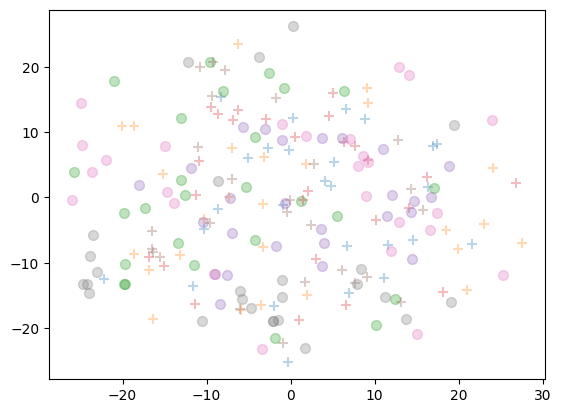

In [426]:
for i in [8,4,49,12,41,24,34,50]:
    if i<30:
        plt.scatter(
            tsne_org[i*26:(i+1)*26, 0],
            tsne_org[i*26:(i+1)*26, 1],
            alpha=0.3,marker='+',
            s=50 )
    else:
        plt.scatter(
            tsne_org[i*26:(i+1)*26, 0],
            tsne_org[i*26:(i+1)*26, 1],
            alpha=0.3,marker='o',
            s=50 )

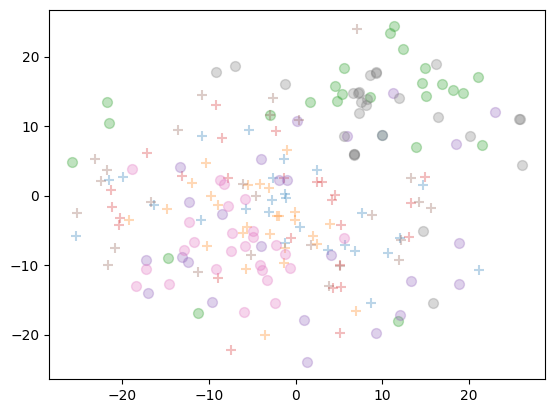

In [428]:
for i in [8,4,49,12,41,24,34,50]:
    if i<30:
        plt.scatter(
            tsne_vae[i*26:(i+1)*26, 0],
            tsne_vae[i*26:(i+1)*26, 1],
            alpha=0.3,marker='+',
            s=50 )
    else:
        plt.scatter(
            tsne_vae[i*26:(i+1)*26, 0],
            tsne_vae[i*26:(i+1)*26, 1],
            alpha=0.3,marker='o',
            s=50 )

In [391]:
tsne_feat=tsne.fit_transform(Adapt_feat_0_0[:,feat_id])

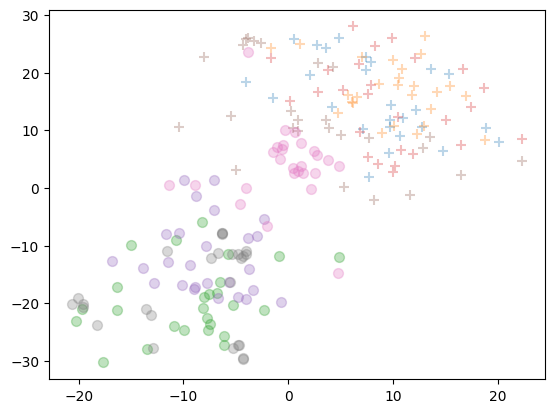

In [429]:
for i in [8,4,49,12,41,24,34,50]:
    if i<30:
        plt.scatter(
            tsne_feat[i*26:(i+1)*26, 0],
            tsne_feat[i*26:(i+1)*26, 1],
            alpha=0.3,marker='+',
            s=50 )
    else:
        plt.scatter(
            tsne_feat[i*26:(i+1)*26, 0],
            tsne_feat[i*26:(i+1)*26, 1],
            alpha=0.3,marker='o',
            s=50 )

# robust_feature_outputs.shape

In [165]:
def OneD_EEGNet(nb_classes=2,dropoutRate = 0.25,norm_rate = 0.25, dropoutType = 'Dropout'):

        input1   = Input(shape = (9568, 1))

        ##################################################################
        block1       = Conv1D(8, (64))(input1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = Conv1D(16, (32))(block1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = AveragePooling1D((4))(block1)
        block1       = Dropout(dropoutRate)(block1)

        block2       = Conv1D(32, (16))(block1)
        block2       = BatchNormalization()(block2)
        block2       = Activation('relu')(block2)

        block2       = AveragePooling1D((8))(block2)
        #block2       = tf.keras.layers.GlobalAveragePooling2D()(block2)
        block2       = Dropout(dropoutRate)(block2)

        flatten      = Flatten(name = 'flatten')(block2)
        initializer = initializer = tf.keras.initializers.Identity()
        dense        = Dense(nb_classes, name = 'dense', 
                             kernel_constraint = max_norm(norm_rate),kernel_initializer=initializer)(flatten)
        softmax      = Activation('softmax', name = 'softmax')(dense)

        return Model(inputs=input1, outputs=softmax)   

In [168]:
 for s in range(1,2):
        
    lr=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001, decay_steps=50, decay_rate=0.9, staircase=False, name=None
    )
    adam=tf.keras.optimizers.Adam(learning_rate=0.0001)#learning_rate=0.0005
    
    model=OneD_EEGNet()
    model.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights = True)
    history=model.fit( robust_feature_outputs.reshape(1404, 9568,1),
                          to_categorical(Y_all_shuffled[s]),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1) 

Epoch 1/100
12/12 [==============================] - 11s 879ms/step - loss: 0.6920 - accuracy: 0.5298 - val_loss: 0.6905 - val_accuracy: 0.5658
Epoch 2/100
12/12 [==============================] - 11s 873ms/step - loss: 0.6310 - accuracy: 0.7079 - val_loss: 0.6859 - val_accuracy: 0.7260
Epoch 3/100
12/12 [==============================] - 11s 874ms/step - loss: 0.5254 - accuracy: 0.8344 - val_loss: 0.6757 - val_accuracy: 0.5836
Epoch 4/100
12/12 [==============================] - 11s 876ms/step - loss: 0.4028 - accuracy: 0.8744 - val_loss: 0.6761 - val_accuracy: 0.4591
Epoch 5/100
12/12 [==============================] - 11s 876ms/step - loss: 0.2951 - accuracy: 0.9074 - val_loss: 0.7200 - val_accuracy: 0.4484
Epoch 6/100
12/12 [==============================] - 10s 872ms/step - loss: 0.2341 - accuracy: 0.9288 - val_loss: 0.8366 - val_accuracy: 0.4448
Epoch 7/100
12/12 [==============================] - 10s 870ms/step - loss: 0.1924 - accuracy: 0.9412 - val_loss: 0.9468 - val_accuracy:

In [169]:
best_weights = model.get_weights()
model.set_weights(best_weights)

In [170]:
#robust_layer_model = Model(inputs=quality_model.input,outputs=quality_model.get_layer('average_pooling1d_1').output)
robust_feature_output_test= robust_layer_model.predict( Xtest[s])


robust_feature_outputs_test=np.zeros([Xtest[s].shape[0],int(299*32)])
for i in range(0,Xtest[s].shape[0]):
    robust_feature_outputs_test[i*26:(i+1)*26,:]=robust_feature_output_test[i,:,:].flatten()

5/5 [==============================] - 0s 26ms/step


In [175]:
robust_feature_outputs_test.shape

(156, 9568)

In [174]:
#model.summary()
Xtest[s].shape

(156, 9736)

In [176]:
for s in range(1,2):
    #classifier=load_model(f'n_set{s}_btw_encoder_T0_classifier')
    classifier=model
    result=[]
    predicted=classifier.predict(robust_feature_outputs_test)
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

5/5 [==============================] - 0s 25ms/step
ep score 0.5
11.384966 14.615033
11.857745 14.142255
11.915186 14.084812
11.391049 14.608952
11.599937 14.400062
11.50978 14.490218
score 0.5
